## Assignment for Week 3 -Applied Data Science Capstone

In this project, the data of toronto postal codes will be used, in order to make segmentations of them, through characteristics of the places near said postal codes.

#### Libraries that I will use in this project

In [65]:
import pandas as pd

import numpy as np

#! pip install geocoder
import geocoder

#!pip install geopy
from geopy.geocoders import Nominatim

#!pip install folium
import folium

import requests

import json
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

### Part 1 - Preparation of the Data

**First we save in the URL variable, the respective url where we want to obtain the table, through web scrapping.**

In [85]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
url

'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

**We read this url, with pandas' own function to read files in html format, which obtains all the generated tables, in this case 3 tables.**

In [86]:
dat=pd.read_html(url)
print(f'Número total de tablas: {len(dat)}')

Número total de tablas: 3


**We select the table of interest in this project, which is the first and we show the first 5 records.**

In [94]:
df = dat[0]
print(df.head())

  Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront


**We show the final dimension of the generated data frame, in this case we can see that it has 180 postal code records with 3 variables (Postal Code, Borough and Neighborhood).**

In [88]:
df.shape

(180, 3)

**We eliminate those records that do not have anything assigned to the Borough variable and show their dimension. We can tell that 77 postal code records were deleted (It started at 180 and now there are 103).**

In [95]:
df = df.drop(df[df['Borough']=="Not assigned"].index, axis=0)
df.shape

(103, 3)

**We check that there are no repeated postal codes with different neighborhoods.**

In [90]:
len(df['Postal Code'].unique())

103

**Number of Neighborhoods with category Not Assigned, there is none, so we continue with the process.**

In [91]:
len(df[df['Neighbourhood']=="Not assigned"].index.tolist())

0

**We rename the postal code field, to avoid confusion, we reset the index and show the first 5 records of the final dataframe.**

In [96]:
df = df.rename(columns={'Postal Code':'postal_code'}).reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,postal_code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Part 2 - Lat/Lon Data Merge

**We load the CSV file of Longitude and Latitude in a variable called geof.**

In [39]:
geof=pd.read_csv('http://cocl.us/Geospatial_data')
geof.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**We perform a data combination, using the dataframe from part 1 of the project with the dataframe of the geographic location of each postal code, through the postal code id and show the first 5 records.**

In [40]:
df2=pd.merge(df, geof, left_on='postal_code', right_on='Postal Code')
df2.drop('Postal Code', axis=1, inplace=True)
df2.head()

,postal_code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


**We can visualize the location of these postal codes through maps created by the folium library, but first we obtain a Toronto landmark through the geolocator library.**

In [41]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


**We plot the points of each postal code on top of the folium map.**

In [42]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighbourhood in zip(df2['Latitude'], df2['Longitude'], df2['Borough'], df2['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Part 3 - Foursquare API Connection and Kmeans Clustering

**First we define the necessary parameters to query the Foursquare API.**

In [49]:
CLIENT_ID = 'IHZ0QMCECCKJ3HRAEDOGM0GBHHHMBEIN0CWXXWA4RLXSUHI5'
CLIENT_SECRET = 'GZ1SGFJRJU2TLWFMQ5NP1OKSOJ4KZSFEFPSPVLPHLDPVOBUF'
VERSION = '20180605'
LIMIT = 100 
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IHZ0QMCECCKJ3HRAEDOGM0GBHHHMBEIN0CWXXWA4RLXSUHI5
CLIENT_SECRET:GZ1SGFJRJU2TLWFMQ5NP1OKSOJ4KZSFEFPSPVLPHLDPVOBUF


**As an objective of the study, we are going to analyze those postal codes that are clearly in the borough of Toronto, so we filter those where the Borough field contains the word "Toronto", we reset the index and show the first 5 records.**

In [44]:
toronto_data=df2[df2['Borough'].str.contains('toronto', case=False)].reset_index()
toronto_data.drop('index', axis=1, inplace=True)
toronto_data.head()

,postal_code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


**We plot those points that belong to Toronto.**

In [46]:
map_toronto2 = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighbourhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto2)  
    
map_toronto2

**We define the necessary functions to obtain the categories of the venues consulted to the Foursquare API, as well as a function that returns all the venues for each postal code.**

In [50]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Postal Code Latitude', 
                  'Postal Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**We use the function created before to obtain a dataframe that contains all the venues for each postal code.**

In [51]:
toronto_venues = getNearbyVenues(names=toronto_data['postal_code'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

M5A
M7A
M5B
M5C
M4E
M5E
M5G
M6G
M5H
M6H
M5J
M6J
M4K
M5K
M6K
M4L
M5L
M4M
M4N
M5N
M4P
M5P
M6P
M4R
M5R
M6R
M4S
M5S
M6S
M4T
M5T
M4V
M5V
M4W
M5W
M4X
M5X
M4Y
M7Y


**We show the dimension and the first 5 records of said dataframe created.**

In [52]:
print(toronto_venues.shape)
toronto_venues.head()

(1594, 7)


,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,M5A,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,M5A,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


**We do a count to see how many venues returned for each postal code.**

In [53]:
toronto_venues.groupby('Postal Code').count()

,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal Code,,,,,,
M4E,5,5,5,5,5,5
M4K,42,42,42,42,42,42
M4L,19,19,19,19,19,19
M4M,37,37,37,37,37,37
M4N,3,3,3,3,3,3
M4P,8,8,8,8,8,8
M4R,20,20,20,20,20,20
M4S,36,36,36,36,36,36
M4T,2,2,2,2,2,2


**We print how many unique venues categories there are in our dataframe.**

In [54]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


**We create dummies variables (1/0) for each category of venue there is, in order to clustering said dataframe. 
We add the postal code as the first column.**

In [55]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postal Code,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**We show the dimension of the dataframe.**

In [56]:
toronto_onehot.shape

(1594, 234)

**We group by each Postal Code and we take the average by category of the dummy variables. If a category has a number close to 1, it is because almost all its venues are of that category and if it is close to 0 or 0, it is because there are no venues with that category. We would already have the data almost ready to model it with a Kmeans algorithm. And show the first 5 records.**

In [57]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped.head()

,Postal Code,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.20000,0.0,0.0,0.0,0.0,0.0,0.000000
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,0.0,...,0.0,0.02381,0.0,0.02381,0.0,0.0,0.0,0.0,0.0,0.023810
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,...,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.027027
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000


**We show the dimension of said dataframe and we can realize that there are 39 postal codes with 233 different categories of venues.**

In [58]:
toronto_grouped.shape

(39, 234)

**We show the first 5 categories of Venues by frequency of each postal code.**

In [59]:
num_top_venues = 5

for hood in toronto_grouped['Postal Code']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Postal Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M4E----
               venue  freq
0  Health Food Store   0.2
1               Park   0.2
2              Trail   0.2
3       Neighborhood   0.2
4                Pub   0.2


----M4K----
                venue  freq
0    Greek Restaurant  0.17
1         Coffee Shop  0.10
2  Italian Restaurant  0.07
3          Restaurant  0.05
4      Ice Cream Shop  0.05


----M4L----
                  venue  freq
0  Fast Food Restaurant  0.11
1                   Gym  0.05
2      Sushi Restaurant  0.05
3                  Park  0.05
4           Coffee Shop  0.05


----M4M----
         venue  freq
0  Coffee Shop  0.08
1    Gastropub  0.05
2       Bakery  0.05
3      Brewery  0.05
4         Café  0.05


----M4N----
            venue  freq
0            Park  0.33
1     Swim School  0.33
2        Bus Line  0.33
3  Adult Boutique  0.00
4          Museum  0.00


----M4P----
                  venue  freq
0  Gym / Fitness Center  0.12
1                 Hotel  0.12
2                  Park  0.12
3      Department 

**We define a function that returns the first n categories of venues for each postal code.**

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**We call the function to return a dataframe that for each postal code returns the first 10 categories of venue by frequency.**

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Pub,Park,Neighborhood,Trail,Health Food Store,Yoga Studio,Dessert Shop,Diner,Discount Store,Distribution Center
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Ice Cream Shop,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
2,M4L,Fast Food Restaurant,Gym,Park,Brewery,Sandwich Place,Restaurant,Pub,Pizza Place,Coffee Shop,Movie Theater
3,M4M,Coffee Shop,Brewery,Gastropub,Café,Bakery,American Restaurant,Yoga Studio,Convenience Store,Cheese Shop,Clothing Store
4,M4N,Bus Line,Park,Swim School,Yoga Studio,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


**We create a dataframe of the dummies variables but without the postal code field, since it will not be used for the Kmeans algorithm.**

In [62]:
toronto_grouped_clustering = toronto_grouped.drop('Postal Code', 1)

**We use an elbow diagram to obtain the number of K clusters to be used within the kmeans algorithm. In this case we choose the value of 5, since it is where a greater fall / peak is appreciated.**

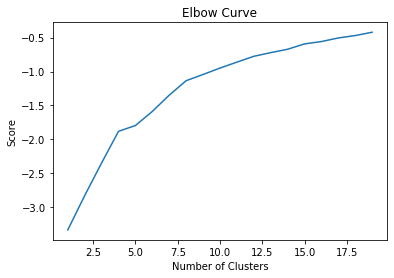

In [66]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(toronto_grouped_clustering).score(toronto_grouped_clustering) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**Using the Kmeans algorithm, we model the category data by postal code and show the labels of the first 10 records.**

In [67]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10] 

array([0, 1, 1, 1, 1, 1, 1, 1, 3, 1])

**We add this information of which cluster each postal code belongs to to the main dataframe where we had the information of the main 10 categories of venue by postal code.**

In [68]:
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

toronto_merged = toronto_merged.join(toronto_venues_sorted.set_index('Postal Code'), on='postal_code')

toronto_merged.head()

,postal_code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Theater,Cosmetics Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Portuguese Restaurant,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Fried Chicken Joint
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Middle Eastern Restaurant,Italian Restaurant,Bubble Tea Shop,Electronics Store,Ramen Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Café,Coffee Shop,Cocktail Bar,American Restaurant,Gastropub,Restaurant,Clothing Store,Moroccan Restaurant,Cosmetics Shop,Creperie
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Park,Neighborhood,Trail,Health Food Store,Yoga Studio,Dessert Shop,Diner,Discount Store,Distribution Center


**We plotted the postal codes on the Toronto map and painted a different color for the cluster to which they belong.**

In [69]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['postal_code'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**We analyze the characteristics of Cluster 0 in the dataframe with all the information of its postal codes.**

In [74]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Park,Neighborhood,Trail,Health Food Store,Yoga Studio,Dessert Shop,Diner,Discount Store,Distribution Center
33,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Playground,Trail,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


**We analyze the characteristics of Cluster 1 in the dataframe with all the information of its postal codes.**

In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Theater,Cosmetics Shop,Shoe Store
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Portuguese Restaurant,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Fried Chicken Joint
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Middle Eastern Restaurant,Italian Restaurant,Bubble Tea Shop,Electronics Store,Ramen Restaurant
3,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Café,Coffee Shop,Cocktail Bar,American Restaurant,Gastropub,Restaurant,Clothing Store,Moroccan Restaurant,Cosmetics Shop,Creperie
5,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cocktail Bar,Restaurant,Bakery,Beer Bar,Farmers Market,Seafood Restaurant,Cheese Shop,Park,Beach
6,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Salad Place,Bubble Tea Shop,Burger Joint,Yoga Studio,Ramen Restaurant,Bike Rental / Bike Share
7,Downtown Toronto,Christie,43.669542,-79.422564,1,Grocery Store,Café,Park,Restaurant,Baby Store,Candy Store,Coffee Shop,Athletics & Sports,Nightclub,Italian Restaurant
8,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,Coffee Shop,Café,Restaurant,Gym,Clothing Store,Deli / Bodega,Thai Restaurant,Sushi Restaurant,Concert Hall,Cosmetics Shop
9,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,1,Pharmacy,Bakery,Park,Music Venue,Supermarket,Bar,Middle Eastern Restaurant,Café,Pool,Bank
10,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,1,Coffee Shop,Aquarium,Hotel,Café,Brewery,Fried Chicken Joint,Scenic Lookout,Restaurant,Italian Restaurant,Bar


**We analyze the characteristics of Cluster 2 in the dataframe with all the information of its postal codes.**

In [76]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,Roselawn,43.711695,-79.416936,2,Home Service,Garden,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


**We analyze the characteristics of Cluster 3 in the dataframe with all the information of its postal codes.**

In [77]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.38316,3,Summer Camp,Restaurant,Yoga Studio,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


**We analyze the characteristics of Cluster 4 in the dataframe with all the information of its postal codes.**

In [78]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,4,Trail,Jewelry Store,Mexican Restaurant,Sushi Restaurant,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


### And this is the end of the project, we will analyze more in depth the results in next week's project, as well as generate a report and give a clearer context to the problem in question. Thanks for your time.